# 📘 Notebook 3: Visualizing Hidden States & Temporal Representation

## Section 1: Introduction & Goals

### 1.1 Recap from NB02
- In **Notebook 2**, we built and trained a **vanilla RNN classifier** for the HAR dataset.  
- We saw that the model can classify activities with reasonable accuracy, but also makes **confusions** (e.g., WALKING vs. WALKING\_UPSTAIRS).  
- We also discussed that vanilla RNNs compress the entire $128 \times 9$ input window into a **single hidden vector $h_T$**.  

But what is this hidden state $h_t$ actually doing as the sequence unfolds?  
👉 In this notebook, we will **open up the black box** and *visualize* how hidden states evolve over time.

---

### 1.2 Why visualize hidden states?
- Hidden states are the **memory** of the RNN.  
- At each timestep $t$, the RNN updates its hidden state using:

$$
h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

- The final hidden state $h_T$ is used for classification, but the **trajectory** $(h_1, h_2, \dots, h_T)$ contains rich information.  

By visualizing $h_t$ across time, we can see:
- How the RNN organizes sensor signals internally.  
- Whether different activities produce distinguishable hidden trajectories.  
- Where the model might **lose or confuse information**.

---

### 1.3 Key questions
As we explore hidden states, keep these questions in mind:
- Do hidden states for **static activities** (SITTING, STANDING, LAYING) look different from those for **dynamic activities** (WALKING, UPSTAIRS, DOWNSTAIRS)?  
- How stable or oscillatory are the hidden states across time?  
- Do trajectories for different activities separate clearly in hidden space, or do they overlap?  

---

### 1.4 Notebook goals
By the end of this notebook, we will:
1. Extract hidden states across all timesteps for sample sequences.  
2. Visualize hidden state dynamics over time for different activities.  
3. Use dimensionality reduction (PCA / t-SNE) to see global patterns across classes.  
4. Reflect on what the RNN is learning — and what it fails to learn.  

This will naturally set up **Notebook 4**, where we connect these visualizations to the **vanishing gradient problem**.


## Section 2: Reload Dataset & Model

### 2.1 What are we reloading — and why?

In NB02, we saved:
- **Standardized datasets** in **CSV** (human-readable; flattened per window) and **NPY** (fast; preserves $(N,128,9)$).  
- **Normalization stats** in `standardization_stats.npz` (not strictly needed here because data are already standardized in the saved files).  
- The **trained model weights** in `rnn_har.pth`.

For this notebook, our goal is to **visualize hidden states**. So we’ll **reload**:
1) the standardized datasets (by **default from CSV**, so we practice reshaping back to $(128,9)$), and  
2) the **trained RNN** so we get meaningful hidden states.

> If we prefer speed, we can switch to the **NPY fast path** shown below.

---

### 2.2 Default loader: CSV (wide → reshape to $(128, 9)$)

- Each row in `har_*_standardized.csv` contains a **flattened** $(128 \times 9)$ window (1152 columns), plus `label` and `subject`.  
- We’ll parse the DataFrame, strip metadata, reshape features to $(128, 9)$, and build PyTorch tensors.

We’ll also create `DataLoader`s, though for visualization we may only need small batches or single sequences.


In [28]:
# 2.2.a CSV loader (default path)

import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

def load_csv_dataset(train_path="har_train_standardized.csv",
                     test_path="har_test_standardized.csv",
                     timesteps=128, channels=9):
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)

    def df_to_arrays(df):
        y = df["label"].values.astype(np.int64)              # (N,)
        subj = df["subject"].values.astype(np.int64)         # (N,)
        X_flat = df.drop(columns=["label","subject"]).values # (N, 1152)
        X = X_flat.reshape(len(df), timesteps, channels)     # (N, 128, 9)
        return X.astype(np.float32), y, subj

    X_train, y_train, subj_train = df_to_arrays(train_df)
    X_test,  y_test,  subj_test  = df_to_arrays(test_df)

    return X_train, y_train, X_test, y_test, subj_train, subj_test

# Load from CSV by default
X_train, y_train, X_test, y_test, subj_train, subj_test = load_csv_dataset()

# Wrap as PyTorch tensors (batch-first: (B, 128, 9))
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

# DataLoaders: for NB03, small batches are fine; we’ll still provide standard loaders
BATCH_SIZE = 96
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t), batch_size=BATCH_SIZE, shuffle=False)

print("Loaded from CSV →",
      "X_train", X_train_t.shape, "| y_train", y_train_t.shape, 
      "| X_test", X_test_t.shape,  "| y_test",  y_test_t.shape)


Loaded from CSV → X_train torch.Size([7352, 128, 9]) | y_train torch.Size([7352]) | X_test torch.Size([2947, 128, 9]) | y_test torch.Size([2947])


### 2.3 Optional fast loader: NPY (already shaped as $(N,128,9)$)

If we prefer speed and don’t need to read the CSVs, we can use the arrays saved in **`.npy`** directly.


In [ ]:
# 2.3.a NPY loader (optional path)

def load_npy_dataset(
    x_train_path="X_train_std.npy",
    y_train_path="y_train.npy",
    x_test_path="X_test_std.npy",
    y_test_path="y_test.npy"
):
    X_train = np.load(x_train_path)  # (N, 128, 9)
    y_train = np.load(y_train_path)
    X_test  = np.load(x_test_path)
    y_test  = np.load(y_test_path)
    return X_train, y_train, X_test, y_test

# Example usage (commented out by default):
# X_train, y_train, X_test, y_test = load_npy_dataset()
# X_train_t = torch.tensor(X_train, dtype=torch.float32)
# y_train_t = torch.tensor(y_train, dtype=torch.long)
# X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
# y_test_t  = torch.tensor(y_test,  dtype=torch.long)
# train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
# test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t), batch_size=64, shuffle=False)
# print("Loaded from NPY →", X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape)


### 2.4 Define the same RNN as NB02 (but return all hidden states)

We’ll reuse the vanilla RNN, but the `forward` method will **return both**:
- `logits` for classification, and  
- the **full hidden sequence** $h_1,\dots,h_T$ (`out_seq`) and the final hidden state `h_n`.

This gives us direct access to the hidden states we want to visualize.


In [29]:
# 2.4.a Model definition (same as NB02 architecture; returns logits + out_seq + h_n)

import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, input_size=9, hidden_size=32, num_classes=6, num_layers=1, nonlinearity="tanh"):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity=nonlinearity,
            batch_first=True,   # (batch, seq, input)
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        x: (batch, seq_len, input_size)
        returns:
          logits: (batch, num_classes)
          out_seq: (batch, seq_len, hidden_size)  # all hidden states
          h_n: (num_layers, batch, hidden_size)   # final hidden state(s)
        """
        out_seq, h_n = self.rnn(x)
        last_hidden = out_seq[:, -1, :]    # (batch, hidden)
        logits = self.fc(last_hidden)      # (batch, classes)
        return logits, out_seq, h_n


### 2.5 Load trained weights (`rnn_har.pth`)

We saved the trained model in NB02 (Section 5.4).  
Let’s load those weights so that the hidden states we visualize reflect a **trained** representation.


In [30]:
# 2.5.a Instantiate model and load checkpoint
model = RNNClassifier(input_size=9, hidden_size=32, num_classes=6, num_layers=1, nonlinearity="tanh")

ckpt_path = "rnn_har.pth"
state = torch.load(ckpt_path, map_location="cpu", weights_only=False)
model.load_state_dict(state)
model.eval()

print("Loaded trained weights from:", ckpt_path)


Loaded trained weights from: rnn_har.pth


### 2.6 Sanity check: forward one batch and inspect shapes

Before we dive into visualizations, let’s confirm that:
- Input shape is $(B, 128, 9)$,  
- `out_seq` is $(B, 128, H)$,  
- `h_n` is $(1, B, H)$,  
- `logits` is $(B, 6)$.


In [31]:
# 2.6.a Quick dry run
import torch.nn.functional as F
xb, yb = next(iter(test_loader))   # or train_loader
logits, out_seq, h_n = model(xb)

print("xb shape      :", tuple(xb.shape))       # (B, 128, 9)
print("out_seq shape :", tuple(out_seq.shape))  # (B, 128, H)
print("h_n shape     :", tuple(h_n.shape))      # (1, B, H)
print("logits shape  :", tuple(logits.shape))   # (B, 6)

probs = F.softmax(logits, dim=1)
print("First row prob sum ~1.0:", float(probs[0].sum()))


xb shape      : (96, 128, 9)
out_seq shape : (96, 128, 32)
h_n shape     : (1, 96, 32)
logits shape  : (96, 6)
First row prob sum ~1.0: 1.0


✅ **Sanity Check Recap**

- Input mini-batch shape: **(96, 128, 9)**  
  → 96 sequences, each 128 timesteps, each timestep with 9 sensor values.  

- Output hidden states: **(96, 128, 32)**  
  → for each sequence, the RNN produced 128 hidden states of size 32.  

- Final hidden state: **(1, 96, 32)**  
  → only the last hidden state per sequence is passed to the classifier.  

- Logits: **(96, 6)**  
  → each sequence compressed into a prediction over 6 activities.  

This confirms our RNN processes temporal data correctly:  
**time → hidden states → last hidden → activity prediction.**


### 2.7 What we’ll visualize next

Now that we can obtain **all hidden states** $h_1,\dots,h_{128}$ for any sequence, we will:

1. Plot hidden state **trajectories over time** for selected examples (e.g., WALKING vs SITTING).  
2. Collect many hidden states and apply **PCA/t-SNE** to see **class separation** in 2D.  
3. Trace **temporal paths** in the reduced space to interpret how the RNN evolves through each activity window.

This sets us up for Sections 3–6.


## 3. Extract Hidden States

### 3.1 🧠 Theory — What are hidden states?

When we pass a sequence through an RNN:

- Each timestep $t$ produces a **hidden state** $h_t$.  
- With `hidden_size = 32`, each $h_t$ is a 32-dimensional vector:
  $$
  h_t = \big[h_t^{(1)}, h_t^{(2)}, \dots, h_t^{(32)}\big].
  $$
- Over 128 timesteps, the model produces 128 such vectors:
  $$
  (h_1, h_2, \dots, h_{128}), \quad h_t \in \mathbb{R}^{32}.
  $$

This gives us a **temporal trajectory** in a 32-dimensional space.

---

### 3.2 🏗️ What the RNN actually outputs

For a batch of $B$ sequences, the forward pass returns:

- **`out_seq`**: all hidden states across time, shape $= (B, 128, H)$  
  (here $B=96$, $H=32$).
- **`h_n`**: the final hidden state(s), shape $= (1, B, H)$.
- **`logits`**: class scores after the FC layer, shape $= (B, 6)$.

So, the RNN is really doing two jobs:
1) Building a **memory trajectory** $h_1 \dots h_{128}$.  
2) Passing the **last hidden state** into a classifier.

---

### 3.3 👀 What we’ll visualize

- Pick one sequence from the batch (e.g., labeled **SITTING**).  
- Extract its hidden states $h_1 \dots h_{128}$.  
- Plot a few hidden dimensions over time (like a “neuron firing curve”).  
- Also plot the **hidden norm** $\lVert h_t \rVert_2$ as a compact summary of how the hidden vector evolves.


In [36]:
# 3.5 Utilities for hidden state exploration

import numpy as np
import torch
import matplotlib.pyplot as plt

# Activity index → readable name
ACTIVITY_MAP = {
    0: "WALKING",
    1: "WALKING_UPSTAIRS",
    2: "WALKING_DOWNSTAIRS",
    3: "SITTING",
    4: "STANDING",
    5: "LAYING",
}

def first_index_of_label(y_batch: torch.Tensor, label_idx: int):
    """Return first index in y_batch == label_idx, or None if not found."""
    y_np = y_batch.cpu().numpy()
    hits = np.where(y_np == label_idx)[0]
    return int(hits[0]) if hits.size > 0 else None

def pick_topk_dims_by_variance(hidden_seq: np.ndarray, k: int = 3):
    """Pick top-k hidden dimensions with highest variance across time."""
    var = hidden_seq.var(axis=0)  # (H,)
    return np.argsort(var)[::-1][:k]

def plot_hidden_dims_over_time(hidden_seq: np.ndarray, dims, title: str):
    """Plot selected hidden dims across timesteps."""
    T = hidden_seq.shape[0]
    t = np.arange(1, T+1)
    plt.figure(figsize=(10,4))
    for d in dims:
        plt.plot(t, hidden_seq[:, d], label=f"h[t, dim={d}]")
    plt.xlabel("Timestep (t)")
    plt.ylabel("Hidden value")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_hidden_norm_over_time(hidden_seq: np.ndarray, title: str):
    """Plot the L2 norm of hidden vector across timesteps."""
    norms = np.linalg.norm(hidden_seq, axis=1)
    t = np.arange(1, hidden_seq.shape[0]+1)
    plt.figure(figsize=(10,3))
    plt.plot(t, norms)
    plt.xlabel("Timestep (t)")
    plt.ylabel("||h_t||_2")
    plt.title(title)
    plt.show()


Batch size B=96, seq_len T=128, hidden_size H=32
Visualizing sample index 31, true label = SITTING


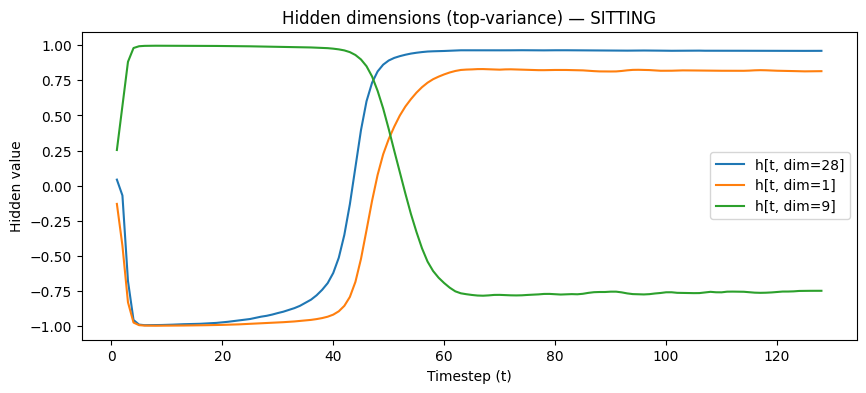

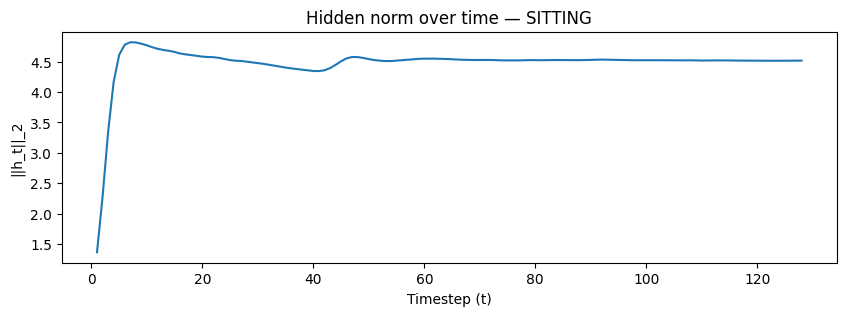

In [37]:
# 3.6 Forward one batch (B=96) and visualize one sequence (SITTING)

# NOTE: make sure your DataLoader was created with batch_size=96 earlier.
xb, yb = next(iter(test_loader))   # xb: (96,128,9), yb: (96,)

model.eval()
with torch.no_grad():
    logits, out_seq, h_n = model(xb)  # out_seq: (96,128,32)

B, T, H = out_seq.shape
print(f"Batch size B={B}, seq_len T={T}, hidden_size H={H}")

# Pick a sample with label = SITTING (class=3); fallback = first sample
target_label = 3
idx = first_index_of_label(yb, target_label)
if idx is None:
    idx = 0
    target_label = int(yb[idx])

print(f"Visualizing sample index {idx}, true label = {ACTIVITY_MAP[int(target_label)]}")

# Hidden states for that sample → (128,32)
hidden_seq = out_seq[idx].cpu().numpy()

# Strategy 1: top-variance dims
topk_dims = pick_topk_dims_by_variance(hidden_seq, k=3)
plot_hidden_dims_over_time(
    hidden_seq, topk_dims,
    title=f"Hidden dimensions (top-variance) — {ACTIVITY_MAP[int(target_label)]}"
)

# Strategy 2: hidden norm
plot_hidden_norm_over_time(
    hidden_seq,
    title=f"Hidden norm over time — {ACTIVITY_MAP[int(target_label)]}"
)


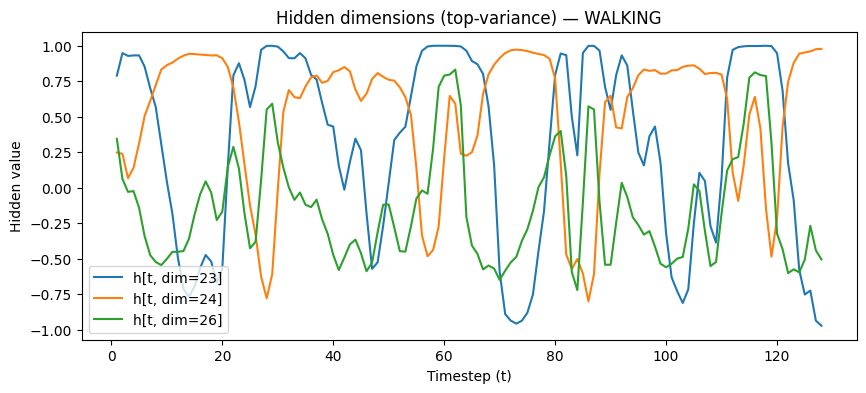

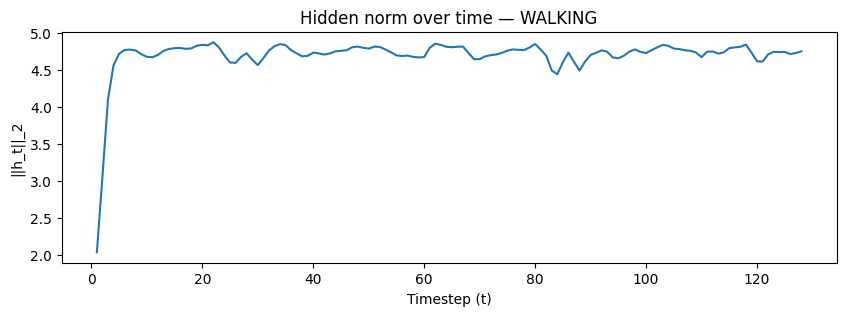

In [38]:
# 3.7 Visualize a contrasting dynamic class (WALKING = 0) from the same batch

target_label_walk = 0
idx_walk = first_index_of_label(yb, target_label_walk)
if idx_walk is not None:
    hidden_seq_walk = out_seq[idx_walk].cpu().numpy()
    topk_dims_walk = pick_topk_dims_by_variance(hidden_seq_walk, k=3)

    plot_hidden_dims_over_time(
        hidden_seq_walk, topk_dims_walk,
        title=f"Hidden dimensions (top-variance) — {ACTIVITY_MAP[target_label_walk]}"
    )

    plot_hidden_norm_over_time(
        hidden_seq_walk,
        title=f"Hidden norm over time — {ACTIVITY_MAP[target_label_walk]}"
    )
else:
    print("No WALKING example found in this batch; re-run the cell to sample another batch.")


### 3.8 Reflection

- **Static vs Dynamic patterns:**  
  For **SITTING**, hidden dimensions often **stabilize** quickly and stay near constant values.  
  For **WALKING**, some hidden dimensions show **oscillations** over time, reflecting periodic motion.

- **Different dims, different roles:**  
  Each hidden neuron (dimension) can specialize in distinct temporal cues; that’s why we select **top-variance** dims to see the most informative activity.

- **Hidden norm as a summary:**  
  The curve of $\lVert h_t \rVert_2$ summarizes how “active” the hidden representation is. Stable norms suggest steady internal state; oscillations or drifts indicate evolving representations.

These views help us interpret **what the RNN is tracking** as the sequence unfolds, and they set us up for the next step: **comparing many sequences in a reduced 2D space (PCA/t-SNE)** to see global structure across classes.


### 🔍 How to interpret these hidden state plots

Each curve in the plot corresponds to **one hidden neuron** (or hidden dimension) inside the RNN.  

- At every timestep $t$, the RNN produces a hidden state vector:
  $$
  h_t = [h_t^{(1)}, h_t^{(2)}, \dots, h_t^{(H)}]
  $$
  where $H=32$ in our case.  

- So $h_t^{(j)}$ is the activation of the **$j$-th hidden neuron** at time $t$.  
  Across the sequence (128 timesteps), each neuron produces a **time-series trace**:
  $$
  h_1^{(j)}, h_2^{(j)}, \dots, h_{128}^{(j)}.
  $$

That’s what we’re plotting: the “firing pattern” of selected hidden neurons as the activity unfolds.  

👉 Notice how different neurons behave differently:
- Some stay flat (stable memory).  
- Some flip from negative to positive (switch-like response).  
- Some oscillate (capturing periodic motion).  

Together, all 32 neurons form a **high-dimensional trajectory** that summarizes the input sequence.  
The final hidden state $h_{128}$ is then used by the classifier to decide the activity label.


## 4. Dimensionality Reduction: PCA / t-SNE on Hidden States

### 4.1 🧠 Theory

- Our RNN hidden states live in a **32-dimensional space** (since `hidden_size = 32`).  
- Humans can’t visualize 32D directly, so we use **dimensionality reduction**:
  - **PCA (Principal Component Analysis):**
    - Linear method.
    - Projects data into directions of maximum variance.
    - Fast and interpretable.
  - **t-SNE (t-distributed Stochastic Neighbor Embedding):**
    - Nonlinear method.
    - Preserves local structure (points close in high-dim remain close in 2D).
    - Slower, but can reveal clusters more clearly.

- Why do this?  
  To check whether **hidden states separate activities**:  
  - Do WALKING samples cluster together?  
  - Do SITTING samples stay distinct?  
  - Or do some activities overlap?

---

### 4.2 🏗️ Implementation Plan

1. Take one batch of test sequences.  
2. Collect all hidden states $h_t$ across all timesteps and sequences:
   - Shape = $(B \times T, H)$ = $(96 \times 128, 32)$.  
3. Apply PCA → 2D scatter plot.  
4. Optionally apply t-SNE → 2D scatter plot.  
5. Color points by activity label.

---


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# 4.3 Collect hidden states from one batch
xb, yb = next(iter(test_loader))  # xb: (B,128,9)
with torch.no_grad():
    logits, out_seq, h_n = model(xb)  # out_seq: (B,128,H)

B, T, H = out_seq.shape
hidden_flat = out_seq.reshape(B*T, H).cpu().numpy()  # (B*T, H)
labels_rep = np.repeat(yb.cpu().numpy(), T)         # repeat each label 128 times

print("Hidden states shape for PCA/TSNE:", hidden_flat.shape)


Hidden states shape for PCA/TSNE: (12288, 32)


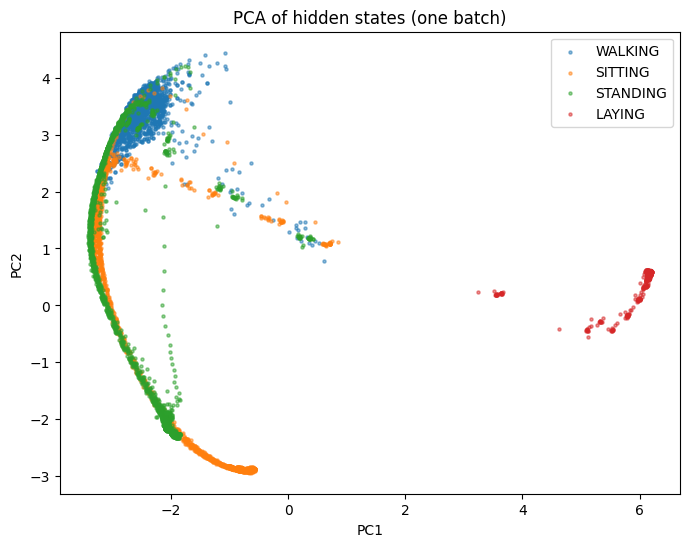

In [ ]:
# 4.4 PCA projection to 2D
pca = PCA(n_components=2)
hidden_pca = pca.fit_transform(hidden_flat)

plt.figure(figsize=(8,6))
for label in np.unique(labels_rep):
    idxs = labels_rep == label
    plt.scatter(hidden_pca[idxs,0], hidden_pca[idxs,1], 
                s=5, alpha=0.5, label=ACTIVITY_MAP[label])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of hidden states (one batch)")
plt.legend()
plt.show()


### 🔍 Understanding PCA Intuitively

We used **PCA (Principal Component Analysis)** to reduce our hidden states (32-dimensional vectors) down to **2D points**.  
But how do we go from 32 numbers to just 2?

---

#### 🧠 Step-by-step intuition

1. **Hidden states in 32D:**  
   - Each hidden state $h_t \in \mathbb{R}^{32}$ is like a vector with 32 coordinates.  
   - We have thousands of such vectors (from 96 sequences × 128 timesteps each).  

2. **Find directions of maximum variance:**  
   - PCA searches for new axes (directions) that capture the **most variation** in the data.  
   - The **first principal component (PC1)** = direction where the data varies the most.  
   - The **second principal component (PC2)** = direction of the next-most variation, orthogonal to PC1.

3. **Project onto 2D:**  
   - Each 32D hidden vector is projected onto these two new axes (PC1 and PC2).  
   - Now every hidden state can be represented as just two numbers:  
     $$
     \text{Hidden state} \; h_t \;\to\; (PC1\_score, \; PC2\_score).
     $$

---

#### 🍀 Analogy

Imagine taking a **shadow of a 3D object** onto a 2D wall:  
- You lose one dimension, but the shadow still shows the **main structure**.  
- PCA works the same way: it chooses the “best wall” (projection) that preserves as much information as possible.

---

#### ✅ What to take away

- Each dot = one hidden state $h_t$ from our RNN.  
- Dots with the same activity label (color) may cluster together if the hidden states encode that activity consistently.  
- Unlike t-SNE, PCA uses **linear projections**, so it may miss some nonlinear structure.  
- But PCA is fast, deterministic, and gives interpretable axes (variance explained by PC1 and PC2).



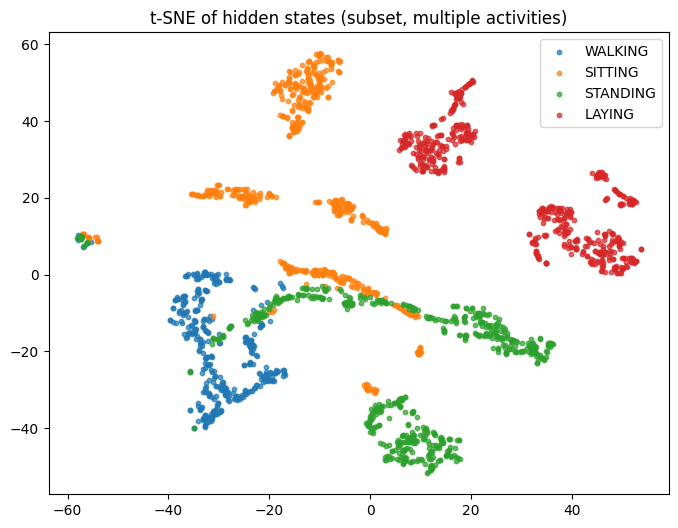

In [44]:
from sklearn.manifold import TSNE

# Flatten across batch & time
hidden_all = out_seq.reshape(-1, H)        # shape (B*T, H)
labels_all = yb.repeat_interleave(T)       # shape (B*T,)

# Subsample for t-SNE (because it’s slow)
n_samples = 2000
idx = np.random.choice(hidden_all.shape[0], n_samples, replace=False)
hidden_subset = hidden_all[idx]
labels_subset = labels_all[idx]

# Apply t-SNE
tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
hidden_2d = tsne.fit_transform(hidden_subset)

# Plot with colors by label
plt.figure(figsize=(8,6))
for lbl in np.unique(labels_subset):
    mask = labels_subset == lbl
    plt.scatter(hidden_2d[mask, 0], hidden_2d[mask, 1], s=10, alpha=0.7, label=ACTIVITY_MAP[int(lbl)])
plt.title("t-SNE of hidden states (subset, multiple activities)")
plt.legend()
plt.show()


### 🔍 Understanding t-SNE Intuitively

We used **t-SNE** to reduce our hidden states (32-dimensional vectors) down to **2D points** for visualization.  
But what do these dots really mean?

---

#### 🧠 Step-by-step intuition

1. **High-dimensional neighbors (32D):**  
   - Each hidden state $h_t \in \mathbb{R}^{32}$ is a point in 32D space.  
   - t-SNE looks at pairs of points and asks: *“How close are they?”*  
   - It converts these distances into probabilities (closer = higher probability of being neighbors).

2. **Create a 2D world:**  
   - All points are placed in a 2D plane.  
   - Again, we define neighbor probabilities, but this time using a different formula (Student-t distribution, which spreads points out more).

3. **Match the two worlds:**  
   - The algorithm moves the 2D points around so that:  
     - If two hidden states were close in 32D, they end up close in 2D.  
     - If they were far apart in 32D, they don’t collapse together in 2D.  
   - This is done by minimizing a mismatch (called KL-divergence) between the two sets of probabilities.

---

#### 🍀 Analogy

Think of it like **flattening a crumpled paper**:

- In 3D (the crumpled ball), two ink dots may be neighbors even if their x/y coordinates look far apart.  
- When we flatten the paper into 2D, we try to keep those neighbor dots still close to each other.  
- We don’t care about the *exact* axes — only about **who stays close and who separates**.

---

#### ✅ What to take away

- Each dot = one hidden state $h_t$ from our RNN.  
- Clusters in 2D suggest the RNN has learned to group certain activities together.  
- The axes (t-SNE dim 1, t-SNE dim 2) **don’t carry meaning** — what matters is the **proximity and clustering**.



### 🔎 Reflection: PCA vs. t-SNE

We now have **two different views** of the same hidden states:

---

#### 🟦 PCA view
- Linear method → looks for **straight-line directions** of maximum variance.  
- Fast, deterministic (everyone sees the same result).  
- Shows rough clusters if activities are well-separated in simple ways.  
- May **miss nonlinear boundaries**, so clusters might overlap.

---

#### 🟧 t-SNE view
- Nonlinear method → preserves **local neighborhoods** (points that were close in 32D stay close in 2D).  
- Great for revealing **complex, curved cluster structures**.  
- Stochastic → each run can look slightly different unless we fix the random seed.  
- Works well when classes are intertwined in nonlinear ways.

---

#### 🧠 What the dots mean
- Each dot = one hidden state $h_t$ at a specific timestep, from one sequence.  
- Color = the activity label of the sequence.  
- If dots of the same color cluster together → the RNN hidden states are encoding useful activity-specific patterns.  
- If clusters overlap → the RNN is struggling to fully separate those activities.

---

#### 🚶 vs 🪑 Example
- **Locomotion activities (WALKING, WALKING_UPSTAIRS, etc.)** often form more dynamic, spread-out clusters.  
- **Static activities (SITTING, STANDING, LAYING)** may form tighter, overlapping groups because their raw signals are more similar.

---

#### ✅ Takeaway
- PCA gives us a **broad, linear “shadow”** of the hidden space.  
- t-SNE zooms in to reveal **nonlinear neighborhood structures**.  
- Together, they help us understand what the RNN is learning — and where it might still be confused.



### 🧭 Why did we do this clustering?

By reducing the 32-dimensional hidden states into 2D, we can **peek inside the RNN’s memory**.  
Instead of treating the model as a black box, these plots show how hidden states arrange themselves:

- If states for the same activity cluster together, it means the RNN has learned an **internal representation** that separates that activity from others.  
- If clusters overlap, it signals **confusion**: the RNN’s hidden space does not clearly separate those activities (e.g., SITTING vs. STANDING).  
- Different reduction methods (PCA, t-SNE) give us complementary views — one linear, one nonlinear — helping us see both the **broad structure** and the **fine details**.

👉 The intuition: these visualizations tell us *how well the RNN is encoding activities in its hidden space*. They reveal **strengths (clear clusters)** and **weaknesses (overlaps)**, guiding us toward improvements like deeper models, LSTMs/GRUs, or better feature engineering.


## 5. Temporal Trajectories in 2D

### 5.1 🧠 Theory — Hidden states as trajectories

So far, we have seen hidden states as *points* in high-dimensional space, clustered via PCA or t-SNE.  
But remember: an RNN produces **a sequence of hidden states**  
$$
h_1, h_2, \dots, h_{128}, \quad h_t \in \mathbb{R}^{32}.
$$  

That means each input sequence traces out a **path (trajectory)** in hidden space.  
- For **dynamic activities** (like WALKING), we expect the trajectory to **oscillate** or wander, reflecting rhythmic motion.  
- For **static activities** (like SITTING), the trajectory may be **stable and compact**, since little is changing over time.

By projecting these high-dimensional vectors into **2D PCA space**, we can literally *see* how the RNN’s memory moves as it processes each timestep.

---

### 5.2 🏗️ Implementation

We’ll:

1. Take one sequence of WALKING and one of SITTING from the test set.  
2. Extract their hidden states $(h_1, \dots, h_{128})$.  
3. Project to 2D using PCA.  
4. Plot the trajectory with arrows to show **time progression**.

---


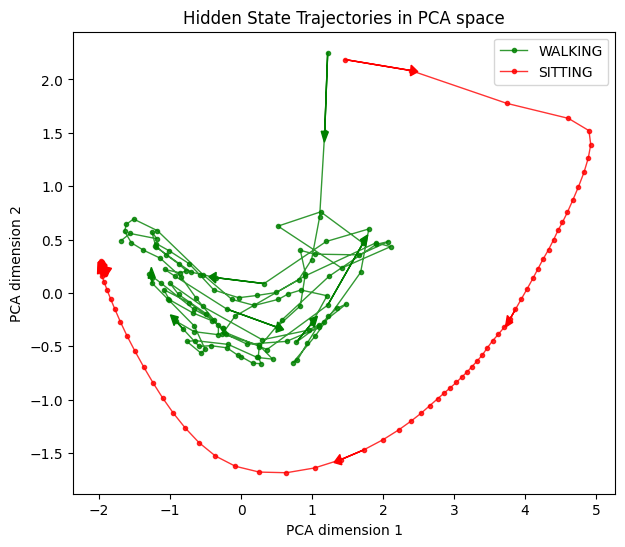

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory(hidden_seq, label, color="blue"):
    """
    hidden_seq: (T, H) numpy array of hidden states
    label: activity string
    """
    # PCA to 2D
    pca = PCA(n_components=2)
    hidden_2d = pca.fit_transform(hidden_seq)  # (T, 2)

    # Plot trajectory with arrows
    plt.plot(hidden_2d[:,0], hidden_2d[:,1], marker="o", markersize=3,
             linewidth=1, color=color, alpha=0.8, label=label)

    # Add arrows for direction (every ~20 timesteps)
    for i in range(0, len(hidden_2d), 20):
        plt.arrow(hidden_2d[i,0], hidden_2d[i,1],
                  hidden_2d[i+1,0]-hidden_2d[i,0],
                  hidden_2d[i+1,1]-hidden_2d[i,1],
                  head_width=0.1, head_length=0.1, fc=color, ec=color)

    return hidden_2d

# --- Pick one WALKING and one SITTING sequence ---
xb, yb = next(iter(test_loader))   # (B,128,9), (B,)
model.eval()
with torch.no_grad():
    logits, out_seq, h_n = model(xb)  # out_seq: (B,128,H)

# Find indices
idx_walk = first_index_of_label(yb, 0)  # WALKING
idx_sit  = first_index_of_label(yb, 3)  # SITTING

plt.figure(figsize=(7,6))

if idx_walk is not None:
    hidden_walk = out_seq[idx_walk].cpu().numpy()
    plot_trajectory(hidden_walk, "WALKING", color="green")

if idx_sit is not None:
    hidden_sit = out_seq[idx_sit].cpu().numpy()
    plot_trajectory(hidden_sit, "SITTING", color="red")

plt.xlabel("PCA dimension 1")
plt.ylabel("PCA dimension 2")
plt.title("Hidden State Trajectories in PCA space")
plt.legend()
plt.show()


### 🌀 Reflection: What do these trajectories mean?

This plot shows how the hidden state vector of the RNN *moves through memory space* as the sequence unfolds (timestep 1 → 128).  

- **WALKING (green)**:  
  The trajectory loops and wiggles, showing that the RNN hidden state keeps **oscillating** in response to the rhythmic motion of walking.  
  👉 Each step leaves its trace in the hidden dynamics.  

- **SITTING (red)**:  
  The trajectory follows a **smooth, stable arc** with little fluctuation.  
  👉 This reflects the static nature of sitting: the RNN receives almost constant sensor input, so the hidden state evolves more steadily.  

#### Intuition
- Each **dot** is a timestep (hidden state $h_t$), and the **arrows** show the direction of time.  
- Dynamic activities trace **complex, oscillatory paths**.  
- Static activities trace **compact, smooth curves**.  

This tells us:  
- RNNs are not just memorizing numbers — they are **embedding entire temporal patterns** into hidden space.  
- Different activities create different "signatures" in hidden space.  

👉 This prepares us for NB04: sometimes these trajectories **overlap** (e.g., SITTING vs. STANDING), which explains *misclassifications* and connects to the idea of vanishing gradients.  


## 6. Summary & Bridge to NB04

### 🧠 Key Lessons
- **Hidden states = evolving memory**: RNNs transform each input into a hidden representation that accumulates information across time.  
- **Static vs. dynamic activities differ**: dynamic actions (like WALKING) produce oscillatory, looping hidden trajectories, while static actions (like SITTING) lead to smoother, stable curves.  
- **Visualizations matter**: PCA and t-SNE helped us “peek inside” the hidden space, showing how activities separate — but also where they overlap.  

### 🔗 Bridge to Next Notebook
- Overlaps in hidden trajectories explain *why the model sometimes misclassifies activities*.  
- In **NB04**, we will go deeper:
  - Investigate **vanishing gradients**, a core limitation of vanilla RNNs.  
  - Perform **per-class error analysis** to see which activities confuse the model.  
  - Set the stage for **advanced RNNs (LSTM/GRU)** in Project 8.  

---

✅ By now, we don’t just treat RNNs as a black box — we’ve seen their **internal memory in action**.
